#### Import CSV and Dependencies

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
filename = "Data/ShotChartDetails0.csv"
rawData = pd.read_csv(filename)

#### Data Filtering
I want to drop unused columns and change the GAME_DATE from YYYYMMDD to a YEAR, MONTH, DATE column

In [3]:
trimmedData = rawData.drop(
    ["GAME_ID", "GRID_TYPE", "PLAYER_ID", "PLAYER_NAME", "TEAM_ID", "TEAM_NAME", "EVENT_TYPE", 
     "SHOT_ATTEMPTED_FLAG", "GAME_EVENT_ID"],1)

dateTimes = pd.to_datetime(trimmedData["GAME_DATE"], format='%Y%m%d')
trimmedData["GAME_DATE"] = dateTimes
trimmedData["YEAR"] = trimmedData["GAME_DATE"].dt.year
trimmedData["MONTH"] = trimmedData["GAME_DATE"].dt.month
trimmedData["DAY"] = trimmedData["GAME_DATE"].dt.day

trimmedData = trimmedData.drop("GAME_DATE",1)

#### Data Visualisation

Plotting Loc_X vs Loc_Y to get a representation of shots made and whether if it went in or not

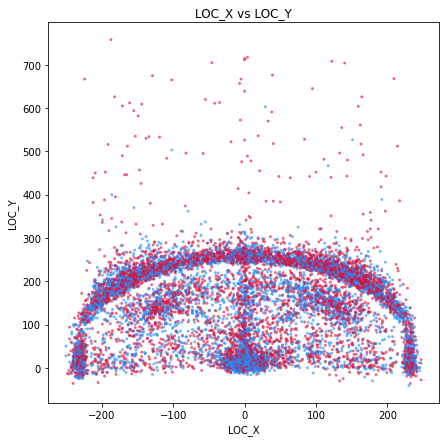

In [4]:
plt.figure(figsize=(7,7))
colors = np.where(trimmedData["SHOT_MADE_FLAG"]==1, "Dodgerblue", "Crimson")
colors.shape

plt.title("LOC_X vs LOC_Y")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
plt.scatter(trimmedData.LOC_X, trimmedData.LOC_Y, color=colors, s=4, alpha=0.5)

Now plotting various points to view distances and shot zones

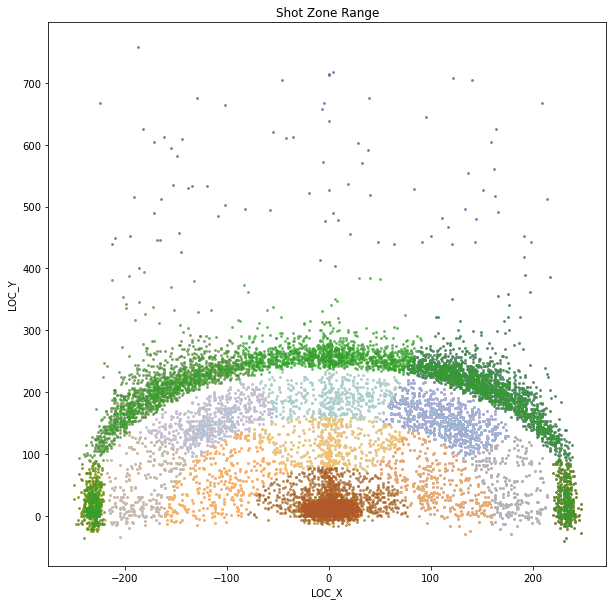

In [5]:
plt.figure(figsize=(10, 10))
def groupedPlotByFeatureAndColorset(feature):
    datasets = trimmedData.groupby(feature)
    colors = cm.Paired(np.linspace(0, 1, len(datasets)))
    for data, color in zip(datasets, colors):
        plt.scatter(data[1].LOC_X, data[1].LOC_Y, color=color, s=3, alpha=0.5)


plt.title("Shot Zone Basic")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
groupedPlotByFeatureAndColorset("SHOT_ZONE_BASIC")

plt.title("Shot Zone Area")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
groupedPlotByFeatureAndColorset("SHOT_ZONE_AREA")

plt.title("Shot Zone Range")
plt.xlabel("LOC_X")
plt.ylabel("LOC_Y")
groupedPlotByFeatureAndColorset("SHOT_ZONE_RANGE")

#### Final bit of data filtering

Additionally, Steph Curry is most known for his shooting. Therefore it makes sense that most of his shots are not lay-ups. Therefore we want to remove any shots that do not have much data associated with it.
To see how much data is associated with each scoring attempt.

In [6]:
trimmedData["ACTION_TYPE"].value_counts()

Jump Shot                             5887
Pullup Jump shot                      1720
Step Back Jump shot                    764
Driving Layup Shot                     647
Layup Shot                             542
Floating Jump shot                     388
Driving Finger Roll Layup Shot         330
Running Jump Shot                      211
Driving Reverse Layup Shot             169
Running Layup Shot                     132
Cutting Layup Shot                     122
Jump Bank Shot                         109
Reverse Layup Shot                     103
Turnaround Jump Shot                    92
Fadeaway Jump Shot                      91
Driving Floating Jump Shot              88
Running Bank shot                       61
Running Finger Roll Layup Shot          52
Running Pull-Up Jump Shot               46
Finger Roll Layup Shot                  36
Driving Bank shot                       36
Driving Floating Bank Jump Shot         35
Running Reverse Layup Shot              35
Driving Jum

Remove rows with the ACTION_TYPE = "Floating Jump shot" and all ACTION_TYPEs below it as well. This is because they contain less than 500 data points and there would not be enough data to create a reliable model with it.

In [7]:
actionTypesToKeep = ["Jump Shot", "Pullup Jump shot", "Step Back Jump shot", "Driving Layup Shot", "Layup Shot"]
trimmedData = trimmedData[trimmedData["ACTION_TYPE"].isin(actionTypesToKeep)]

Also, change the HTM and VTM columns into 1 column with a binary of 1 - Home, 0 - Visitor and remove the HTM AND VTM column

In [8]:
trimmedData["HOME"] = np.where(trimmedData["HTM"] == "GSW", 1, 0)
trimmedData = trimmedData.drop(["HTM", "VTM"], 1)

Additionally, change the "SHOT_TYPE" into a binary of 1 - 3Pt Field Goal and 0 - 2Pt Field Goal

In [9]:
trimmedData["SHOT_TYPE"] = np.where(trimmedData["SHOT_TYPE"] == "3PT Field Goal", 1, 0)

#### More retooling of data
This will preform one-hot encoding of the SHOT_ZONE_BASIC, SHOT_ZONE_AREA, and ACTION_TYPE columns

In [10]:
# for SHOT_ZONE_BASIC
zoneTypes = ["ZONE_ABOVE_THE_BREAK_3", "ZONE_BACKCOURT", "ZONE_IN_THE_PAINT_(NON-RA)", "ZONE_LEFT_CORNER_3",
             "ZONE_MID_RANGE", "ZONE_RESTRICTED_AREA", "ZONE_RIGHT_CORNER_3"]
dumDfZoneBasic = pd.get_dummies(trimmedData["SHOT_ZONE_BASIC"], columns=zoneTypes)
trimmedData = trimmedData.join(dumDfZoneBasic)


In [11]:
# for SHOT_ZONE_AREA
areaTypes = ["AREA_BACK_COURT", "AREA_CENTER", "AREA_LEFT_SIDE_CENTER", "AREA_LEFT SIDE", "AREA_RIGHT SIDE CENTER",
             "AREA_RIGHT SIDE"]
dumDfArea = pd.get_dummies(trimmedData["SHOT_ZONE_AREA"], columns=areaTypes)
trimmedData = trimmedData.join(dumDfArea)

In [12]:
# for ACTION_TYPE
actionTypesToKeep = ["Jump Shot", "Pullup Jump shot", "Step Back Jump shot", "Driving Layup Shot", "Layup Shot"]
dumDfActionType = pd.get_dummies(trimmedData["ACTION_TYPE"], columns=actionTypesToKeep)
trimmedData = trimmedData.join(dumDfActionType)

Combining loc_x vs loc_y. Since both of these values are related to each other it is possible that overfitting will occur, but it is important to ensure that they are both captured in the model. Therefore, take the ratio of the two values with loc_x/loc_y. Also remove the LOC_X and LOC_Y column because it is not needed anymore. However, before the division takes place loc_x and loc_y must be standardised because there could be cases with 0/0 division.

In [ ]:
trimmedData[["LOC_X", "LOC_Y"]] = StandardScaler().fit_transform(trimmedData[["LOC_X", "LOC_Y"]])

In [13]:
trimmedData["LOC_RATIO"] = trimmedData["LOC_X"]/trimmedData["LOC_Y"]
trimmedData = trimmedData.drop(["LOC_X", "LOC_Y"], 1)

In [14]:
trimmedData["LOC_RATIO"] = trimmedData["LOC_X"]/trimmedData["LOC_Y"]
trimmedData = trimmedData.drop(["LOC_X", "LOC_Y"], 1)

Finally, we do not need the three columns that was converted with one hot encoding along with SHOT_ZONE_RANGE

In [15]:
trimmedData = trimmedData.drop(["SHOT_ZONE_BASIC", "SHOT_ZONE_AREA", "ACTION_TYPE", "SHOT_ZONE_RANGE"], 1)

In [16]:
trimmedData.to_csv('Data/ModelData.csv', index=False, header=True)